# **Heart Failure Prediction**
Project by Francisco Uriel Olivas Márquez
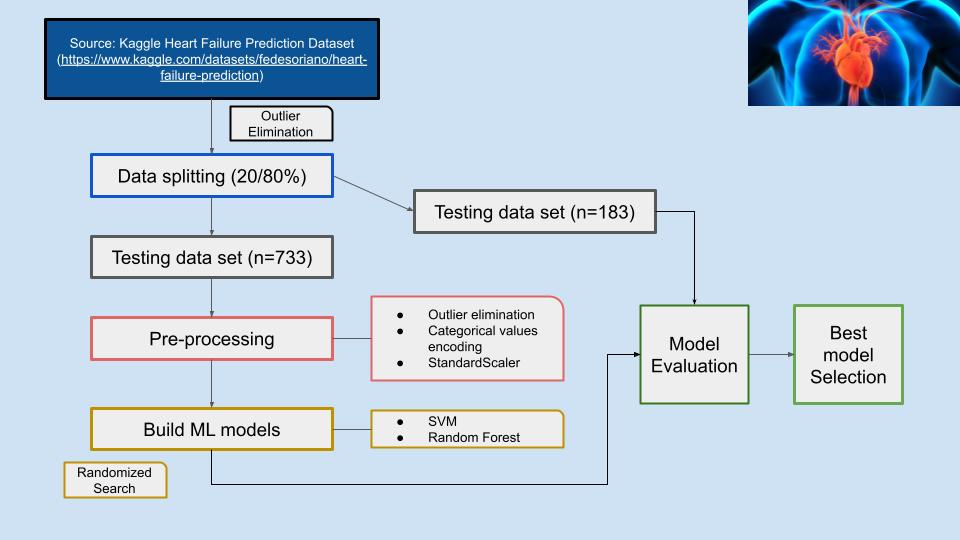

Heart Failure Prediction using Machine Learning. Implemented in Python using a public dataset from Kaggle.

In [70]:
## 1. EXPLORATORY DATA ANALYSIS ##
import pandas as pd
import plotly.express as px

data = pd.read_csv("heart.csv")

print("DATA HEAD \n", data.head())
print("___________________________________")
print("DATA INFO")
print(data.info())
print("___________________________________")
print("DATA DESCRIBE \n", data.describe())
print("___________________________________")

for col in data.select_dtypes(include=['object']).columns:
    print(f"Columna: {col}")
    print(data[col].unique())
    print("___________________________________")

print("___________________________________")

datadrop = data.drop(columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], axis=1)
print(datadrop.corr())

# DATA VISUALIZATION
# Scatter Plots (con colores por HeartDisease)
fig = px.scatter(data, x='Age', y='MaxHR', color='HeartDisease', title="Scatter Plot: Age vs MaxHR")
fig.show()

fig = px.scatter(data, x='HeartDisease', y='MaxHR', color='Sex', title="Scatter Plot: MaxHR")
fig.show()

fig = px.scatter(data, x='HeartDisease', y='Oldpeak', color='Sex', title="Scatter Plot: Oldpeak")
fig.show()

# Box Plots (coloreados por HeartDisease)
fig_box = px.box(data, y='Age', color='HeartDisease', title="Age Box Plot")
fig_box.show()

fig_box = px.box(data, y='RestingBP', color='HeartDisease', title="RestingBP Box Plot")
fig_box.show()

fig_box = px.box(data, y='Cholesterol', color='HeartDisease', title="Cholesterol")
fig_box.show()

fig_box = px.box(data, y='Oldpeak', color='HeartDisease', title="Oldpeak")
fig_box.show()

# Bar plots
counts = data['HeartDisease'].value_counts().reset_index() # Count category frequency
counts.columns = ['HeartDisease', 'Cantidad']
fig = px.bar(counts, x='HeartDisease', y='Cantidad', title="People with/without Heart Disease")
fig.show()

counts = data['Sex'].value_counts().reset_index()
counts.columns = ['Sex', 'Cantidad']
fig = px.bar(counts, x='Sex', y='Cantidad', color='Sex', title="Amount of people by Sex")
fig.show()

## Outlier Elimination
data = data[data['RestingBP'] != 0]
data = data[data['Cholesterol'] != 0]

fig_box = px.box(data, y='RestingBP', color='HeartDisease', title="RestingBP Box Plot (without outliers)")
fig_box.show()

fig_box = px.box(data, y='Cholesterol', color='HeartDisease', title="Cholesterol Box Plot (without outliers)")
fig_box.show()


DATA HEAD 
    Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
___________________________________
DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  

The dataset has 918 entries. All of them are non-null and the categorical data doesn't have typing errors. The box plots helped to visualize outliers in the numerical data, especifically in Cholesterol and RestingBP. I decided to eliminate those instances due to wrong measurements. (It's impossible to get a Cholesterol or BP of zero). Also, the classes are slightly unbalanced but for now I won't worry about that.

In [71]:
## 2. DATA DIVISION ##
from sklearn.model_selection import train_test_split
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Distribution:")
print(y_train.value_counts())

Distribution:
HeartDisease
0    312
1    284
Name: count, dtype: int64


I use stratify to maintain the class distribution in both sets.

In [72]:
## 3. PREPROCESSING ##
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Transform Categorical Values
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


The categorical values must be transformed into numerical values in order to be used in model training.
*get_dummies* replaces each column into binary for each category. (One-hot encoding).

*StandardScaler* is used to bring all features to the same magnitude. *fit_transform* learns the train datase and uses the same mean and standard deviation in test (avoiding data  leakage).

In [73]:
## 4. MODEL TRAINING ##
## SVM
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform

# Hyperparameters
param_dist = {
    'C': uniform(loc=0.1, scale=10),
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'class_weight': ['balanced']
}

# Base Model
svm = SVC(probability=True, random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,                   # 5-fold cross-validation
    scoring='f1',           # F1-score
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Training
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e2a8cc71190>,
                                        'class_weight': ['balanced'],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['rbf', 'linear', 'poly',
                                                   'sigmoid']},
                   random_state=42, scoring='f1', verbose=2)

SVM is trained. I used RandomizedSearchCV to find the best hyperparameters.

In [74]:
from sklearn.ensemble import RandomForestClassifier

## 4b. RANDOM FOREST MODEL TRAINING ##
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Parámetros para RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=20,
    cv=5,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento
random_search_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='f1', verbose=2)

Random Forest is trained. I used RandomizedSearchCV to find the best hyperparameters.

In [75]:
#MODEL EVALUATION
# SVM Results
print("Best Parameters:", random_search.best_params_)
best_svm = random_search.best_estimator_
# Confusion Matrix and Classification Report
y_pred_best = best_svm.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

# Random Forest Results
print("Random Forest - Best Parameters:", random_search_rf.best_params_)
best_rf = random_search_rf.best_estimator_
# Confusion Matrix and Classification Report
y_pred_rf = best_rf.predict(X_test_scaled)
print("Random Forest - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))


Best Parameters: {'C': np.float64(1.9182496720710063), 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
[[63 15]
 [ 6 66]]
              precision    recall  f1-score   support

           0       0.91      0.81      0.86        78
           1       0.81      0.92      0.86        72

    accuracy                           0.86       150
   macro avg       0.86      0.86      0.86       150
weighted avg       0.87      0.86      0.86       150

Random Forest - Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True}
Random Forest - Confusion Matrix:
[[63 15]
 [ 8 64]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        78
           1       0.81      0.89      0.85        72

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.85      0.85 

In [76]:
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['No HD', 'HD']
    fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=labels,
        y=labels,
        hoverongaps=False,
        colorscale='Viridis',
        reversescale=True,
        text=cm,
        texttemplate="%{text}",
        textfont={"size":20}
    ))
    fig.update_layout(
        title=title,
        xaxis_title="Predicted Label",
        yaxis_title="True Label",
        yaxis_autorange='reversed',
        width=500,
        height=450,
        font=dict(size=16)
    )

    fig.show()

#SVM
plot_confusion_matrix(y_test, y_pred_best, "SVM Confusion Matrix")
#Random Forest
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")


The results are satisfactory. SVM performs slightly better than Random Forest with an 86% of accuracy. Maybe this can be improved by balancing the classes? Let's see.

In [78]:
data = pd.read_csv("heart.csv")
## Outlier Elimination
data = data[data['RestingBP'] != 0]
data = data[data['Cholesterol'] != 0]

## 2. DATA DIVISION ##
from sklearn.model_selection import train_test_split
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==============================
# OVERSAMPLING
# ==============================
from sklearn.utils import resample
train = pd.concat([X_train, y_train], axis=1)

# Separe classes
df_majority = train[train['HeartDisease'] == 1]
df_minority = train[train['HeartDisease'] == 0]

# Oversampling minority class
df_minority_oversampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# Balanced training dataset
train_balanced = pd.concat([df_majority, df_minority_oversampled])

# New X_train and y_train
X_train = train_balanced.drop("HeartDisease", axis=1)
y_train = train_balanced["HeartDisease"]
print("Training dataset distribution after Oversampling:")
print(y_train.value_counts())

## 3. PREPROCESSING ##
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
# Transform Categorical Values
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 4. MODEL TRAINING #
param_dist = {
    'C': uniform(loc=0.1, scale=10),
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'class_weight': ['balanced']
}
svm = SVC(probability=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Training
random_search.fit(X_train_scaled, y_train)

## 4b. RANDOM FOREST MODEL TRAINING ##
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search_rf.fit(X_train_scaled, y_train)

#MODEL EVALUATION
# SVM Results
print("Best Parameters:", random_search.best_params_)
best_svm = random_search.best_estimator_
# Confusion Matrix and Classification Report
y_pred_best = best_svm.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

# Random Forest Results
print("Random Forest - Best Parameters:", random_search_rf.best_params_)
best_rf = random_search_rf.best_estimator_
# Confusion Matrix and Classification Report
y_pred_rf = best_rf.predict(X_test_scaled)
print("Random Forest - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))


Distribución después de sobremuestreo:
HeartDisease
1    284
0    284
Name: count, dtype: int64
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'C': np.float64(3.408980248526492), 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'poly'}
[[65 13]
 [ 6 66]]
              precision    recall  f1-score   support

           0       0.92      0.83      0.87        78
           1       0.84      0.92      0.87        72

    accuracy                           0.87       150
   macro avg       0.88      0.88      0.87       150
weighted avg       0.88      0.87      0.87       150

Random Forest - Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Random Forest - Confusion Matrix:
[[65 13]
 [ 7 65]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.90      0

I used the same preprocessing and training of the models. The only change is that I added oversampling of the minority class (HD=0), using resample, which duplicates some of the instances until the classes are balanced.

In [79]:
#SVM
plot_confusion_matrix(y_test, y_pred_best, "SVM Confusion Matrix")
#Random Forest
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")

#Conclusions

###Before Oversampling

* 86% accuracy with SVM, slightly better than Random Forest.

* Class imbalance existed: more patients with Heart Disease (1) than without (0).

* Because of that imbalance, the model risked being biased toward predicting the majority class (disease = 1). Precision and recall for the minority class (0 = no heart disease) were lower.

###After Oversampling
* Small improvements in both models.
SVM and Random Forest now perform almost identically, both achieving 87% accuracy.

* Balancing the dataset improved performance.
Before oversampling, the models favored predicting "Heart Disease" (majority class).
After oversampling, both classes are equally well predicted (F1 = 0.87 for both).

* SVM is slightly better at recall for class 1 (detecting sick patients), useful if the priority is detecting as many patients with heart disease as possible, but Random Forest is slightly better at precision for class 0, necessary if the priority is avoiding false alarms in healthy patients.

Both models achieve strong, balanced results after oversampling. In the future it's possible to implement different Machine Learning models like Neural Networks and stronger feature engineering to improve the metrics.